In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from util.Affine_Transformations import generate_strain_tensors
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
file_path = "data/DeDoDe_Descriptors_Dataset.pth"
data = torch.load(file_path)
base_descriptors = data['descriptors']
base_descriptors = base_descriptors / torch.norm(base_descriptors,dim=-1,keepdim=True)
transformed_descriptors = data['deformed_descriptors']
transformed_descriptors = transformed_descriptors / torch.norm(transformed_descriptors,dim=-1,keepdim=True)
transformation_idxs = data['transformations']
transformation_idxs = torch.repeat_interleave(transformation_idxs, repeats=11, dim=1).flatten()
transformation_list = np.array(generate_strain_tensors())
parameters = torch.tensor(transformation_list[transformation_idxs])
print(f'Mean Cosine Similarity: {torch.nn.functional.cosine_similarity(base_descriptors,transformed_descriptors,dim = 1).mean()}')
print(f'Mean L2 Distance: {torch.norm(base_descriptors-transformed_descriptors,dim=1).mean()}')

/tmp/ipykernel_9595/2847955309.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Mean Cosine Similarity: 0.6012873409031987
Mean L2 Distance: 0.8634952713972927


In [5]:
norms = torch.norm(base_descriptors,dim=-1)
print(norms.mean())

tensor(1., dtype=torch.float64)


In [6]:
# Create a dataset and dataloader
dataset = TensorDataset(base_descriptors, transformed_descriptors, parameters)
# dataset = TensorDataset(all_base_descriptors, all_transformed_descriptors)
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_dataset, val_dataset, test_dataset = random_split(dataset,[train_size,val_size,test_size])

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last = False, num_workers=32,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last = False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last = False)

In [7]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, num_layers=1):
        super(MLP, self).__init__()

        layers = []

        if num_layers == 0:
            layers.append(nn.Linear(input_dim, output_dim))
        else:
            # First hidden layer
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())

            for _ in range(num_layers - 1):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
# Define residual MLP model
class Residual_MLP(nn.Module):
    def __init__(self, input_dim, parameter_dim, output_dim, hidden_dim=256):
        super(Residual_MLP, self).__init__()
        self.model = nn.Sequential(
            # nn.Linear(input_dim,output_dim)
            
            # nn.Linear(input_dim, hidden_dim),
            # # nn.BatchNorm1d(hidden_dim),
            # nn.ReLU(),
            # nn.Linear(hidden_dim, output_dim)
            
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x, parameters):
        residual = self.model(x)
        return x + residual

In [9]:
# Define conditional residual MLP
class Conditional_Residual_MLP(nn.Module):
    def __init__(self, input_dim, parameter_dim, output_dim, hidden_dim=256, num_layers=1):
        super(Conditional_Residual_MLP, self).__init__()
        
        layers = []

        if num_layers == 0:
            layers.append(nn.Linear(input_dim + parameter_dim, output_dim))
        else:
            # First hidden layer
            layers.append(nn.Linear(input_dim + parameter_dim, hidden_dim))
            layers.append(nn.ReLU())

            for _ in range(num_layers - 1):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, parameters):
        combined = torch.cat([x, parameters], dim = -1)
        residual = self.model(combined)
        return x + residual

In [10]:
# Define embedded residual conditional MLP
class Embedded_Conditional_Residual_MLP(nn.Module):
    def __init__(self, input_dim, parameter_dim, output_dim, hidden_dim=256, embed_dim=64, num_layers = 1):
        super(Embedded_Conditional_Residual_MLP, self).__init__()

        self.parameter_embed = nn.Sequential(
            nn.Linear(parameter_dim, embed_dim)
        )

        
        layers = []

        if num_layers == 0:
            layers.append(nn.Linear(input_dim + embed_dim, output_dim))
        else:
            # First hidden layer
            layers.append(nn.Linear(input_dim + embed_dim, hidden_dim))
            layers.append(nn.ReLU())

            for _ in range(num_layers - 1):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.ReLU())

            layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x, parameters):
        embedded_parameters = self.parameter_embed(parameters)
        combined = torch.cat([x, embedded_parameters], dim = -1)
        residual = self.mlp(combined)
        return x + residual

In [11]:
# Define enhanced residual conditional MLP
class Enhanced_Conditional_Residual_MLP(nn.Module):
    def __init__(self, input_dim, parameter_dim, output_dim, hidden_dim=256, enhance_factor=1):
        super(Enhanced_Conditional_Residual_MLP, self).__init__()

        self.enhance_factor = enhance_factor
        
        self.mlp = nn.Sequential(
            # nn.Linear(input_dim,output_dim)
            
            # nn.Linear(input_dim + parameter_dim, hidden_dim),
            # # nn.BatchNorm1d(hidden_dim),
            # nn.ReLU(),
            # nn.Linear(hidden_dim, output_dim)
            
            nn.Linear(input_dim + parameter_dim*enhance_factor, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x, parameters):
        enhanced_parameters = torch.repeat_interleave(parameters, self.enhance_factor, dim=1)
        combined = torch.cat([x, enhanced_parameters], dim = -1)
        residual = self.mlp(combined)
        return x + residual

In [12]:
# Define Mixture of Experts Model
class Residual_Mixture_Of_Experts(nn.Module):
    def __init__(self, input_dim, parameter_dim, output_dim, hidden_dim=256, num_experts = 3):
        super(Residual_Mixture_Of_Experts, self).__init__()

        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim + parameter_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            ) for _ in range(num_experts)
        ])

        
        self.gating = nn.Sequential(
            nn.Linear(parameter_dim, num_experts),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x, parameters):
        combined = torch.cat([x, parameters], dim = -1)
        expert_outputs = torch.stack([expert(combined) for expert in self.experts], dim=-1)
        weights = self.gating(parameters).unsqueeze(1)
        residual = torch.sum(expert_outputs * weights, dim=-1)
        return x + residual

In [13]:
# Define HyperNetwork
class HyperNetwork(nn.Module):
    def __init__(self, input_dim, parameter_dim, output_dim, hidden_dim=256):
        super(HyperNetwork, self).__init__()

        self.weights_model = nn.Sequential(
            nn.Linear(parameter_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, (input_dim)*input_dim)
        )

    
    def forward(self, x, parameters):
        weights = self.weights_model(parameters).view(-1,output_dim,input_dim)
        x_unsq = x.unsqueeze(1)
        residual = torch.bmm(x_unsq, weights.transpose(1,2).squeeze(1))
        return x + residual

In [14]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
input_dim = base_descriptors.shape[1]
output_dim = transformed_descriptors.shape[1]
parameter_dim = parameters.shape[1]
# model = MLP(input_dim,output_dim).double().to(device)
# model = Conditional_Residual_MLP(input_dim,parameter_dim,output_dim,hidden_dim = 512, num_layers = 4).double().to(device)
# model = Enhanced_Conditional_Residual_MLP(input_dim,parameter_dim,output_dim,enhance_factor = 10).double().to(device)
model = Embedded_Conditional_Residual_MLP(input_dim,parameter_dim,output_dim,hidden_dim=1024,embed_dim=32,num_layers = 5).double().to(device)
# model = Residual_Mixture_Of_Experts(input_dim, parameter_dim, output_dim, num_experts = 3).double().to(device)
# model = HyperNetwork(input_dim,parameter_dim, output_dim).double().to(device)

cuda


In [15]:
# Potentially apply identity initialisation to model
identity_initialisation = True

def init_identity(m):
    if isinstance(m, nn.Linear):
        nn.init.eye_(m.weight)  # Initialize as identity
        if m.bias is not None:
            nn.init.zeros_(m.bias)

if identity_initialisation and isinstance(model,MLP):
    model.apply(init_identity)
    print('identity applied')


In [16]:
# Define loss function and optimizer
def cosine_loss(output,target,reduction = 'mean'):
    loss = 1 - torch.nn.functional.cosine_similarity(output,target)

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'none':
        return loss

def l2_loss(output, target, reduction = 'mean'):
    loss = torch.norm(output-target,p=2,dim=1)

    if reduction == 'none':
        return loss
    else:
        return loss.mean()

# criterion = nn.CosineEmbeddingLoss(reduction='none')
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [17]:
# One eval round before training
lambda_mse = 0.2

model.eval()
start_losses = []
with torch.no_grad():
    for base, transformed, param in val_dataloader:
        base, transformed, param = base.to(device), transformed.to(device), param.to(device)
        output = model(base, param)
        # losses = l2_loss(output,transformed, reduction = 'none')
        losses = cosine_loss(output,transformed,'none')
        loss = losses.mean()
        start_losses.extend(losses.cpu().numpy())

start_loss = np.mean(start_losses)
print(f'Loss before training: {start_loss}')

writer = SummaryWriter(log_dir="runs/tain_model")

# Training loop
epochs = 250
for epoch in range(epochs):
    model.train()
    train_losses = []
    for base, transformed, param in train_dataloader:
        base, transformed, param = base.to(device), transformed.to(device), param.to(device)
        
        optimizer.zero_grad()
        output = model(base, param)
        # losses = l2_loss(output, transformed)
        losses = cosine_loss(output,transformed,'none') #+ lambda_mse * l2_loss(output, transformed) 
        loss = losses.mean()
        loss.backward()
        optimizer.step()
        
        train_losses.extend(losses.cpu().detach().numpy())

    model.eval()
    val_losses = []
    val_l2s = []
    val_cosines = []
    with torch.no_grad():
        for base, transformed, param in val_dataloader:
            base, transformed, param = base.to(device), transformed.to(device), param.to(device)
            output = model(base, param)
            # losses = l2_loss(output,transformed,'none')
            l2s = l2_loss(output,transformed,'none')
            losses = cosine_loss(output,transformed,'none')
            cosines = 1 - cosine_loss(output,transformed,'none')
            val_losses.extend(losses.cpu().numpy())
            val_cosines.extend(cosines.cpu().numpy())
            val_l2s.extend(l2s.cpu().numpy())
            
    avg_train_loss = np.mean(train_losses)
    std_train_loss = np.std(train_losses)

    avg_val_loss = np.mean(val_losses)
    std_val_loss = np.std(val_losses)

    avg_val_cos = np.mean(val_cosines)
    std_val_cos = np.std(val_cosines)

    avg_val_l2 = np.mean(val_l2s)
    std_val_l2 = np.std(val_l2s)

    writer.add_scalar("Train/Loss", avg_train_loss, epoch)
    writer.add_scalar("Train/Loss_std", std_train_loss, epoch)
    writer.add_scalar("Validation/Loss", avg_val_loss, epoch)
    writer.add_scalar("Validation/Cosine", avg_val_cos, epoch)
    writer.add_scalar("Validation/L2", avg_val_l2, epoch)
    writer.add_scalar("Validation/Loss_std", std_val_loss, epoch)
    writer.add_scalar("Validation/Cosine_std", std_val_cos, epoch)
    writer.add_scalar("Validation/L@_std", std_val_l2, epoch)

    scheduler.step(avg_val_loss)
    

    if (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Val L2: {avg_val_l2:.6f}, Val Cos: {avg_val_cos:.6f}")

Loss before training: 0.42363112957187055
Epoch 5/250, Train Loss: 0.334646, Val Loss: 0.331645, Val L2: 1.052003, Val Cos: 0.668355
Epoch 10/250, Train Loss: 0.309817, Val Loss: 0.311781, Val L2: 1.138948, Val Cos: 0.688219
Epoch 15/250, Train Loss: 0.293023, Val Loss: 0.298503, Val L2: 1.172856, Val Cos: 0.701497
Epoch 20/250, Train Loss: 0.279683, Val Loss: 0.288828, Val L2: 1.217116, Val Cos: 0.711172
Epoch 25/250, Train Loss: 0.268618, Val Loss: 0.280832, Val L2: 1.208412, Val Cos: 0.719168
Epoch 30/250, Train Loss: 0.258800, Val Loss: 0.275156, Val L2: 1.217491, Val Cos: 0.724844
Epoch 35/250, Train Loss: 0.250035, Val Loss: 0.269564, Val L2: 1.212583, Val Cos: 0.730436
Epoch 40/250, Train Loss: 0.242047, Val Loss: 0.265700, Val L2: 1.207118, Val Cos: 0.734300
Epoch 45/250, Train Loss: 0.234578, Val Loss: 0.261477, Val L2: 1.231179, Val Cos: 0.738523
Epoch 50/250, Train Loss: 0.227779, Val Loss: 0.257790, Val L2: 1.230079, Val Cos: 0.742210
Epoch 55/250, Train Loss: 0.221327, Val

In [18]:
# Save the trained model
torch.save(model.to(torch.float32).state_dict(), "models/stretcher_normalised.pth")
print("Model training complete and saved.")

Model training complete and saved.


In [20]:
model.load_state_dict(torch.load("models/stretcher_normalised.pth"))
model.eval()

/tmp/ipykernel_9595/999692410.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/stretcher_normalised.pth"))


Embedded_Conditional_Residual_MLP(
  (parameter_embed): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=288, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=256, bias=True)
  )
)

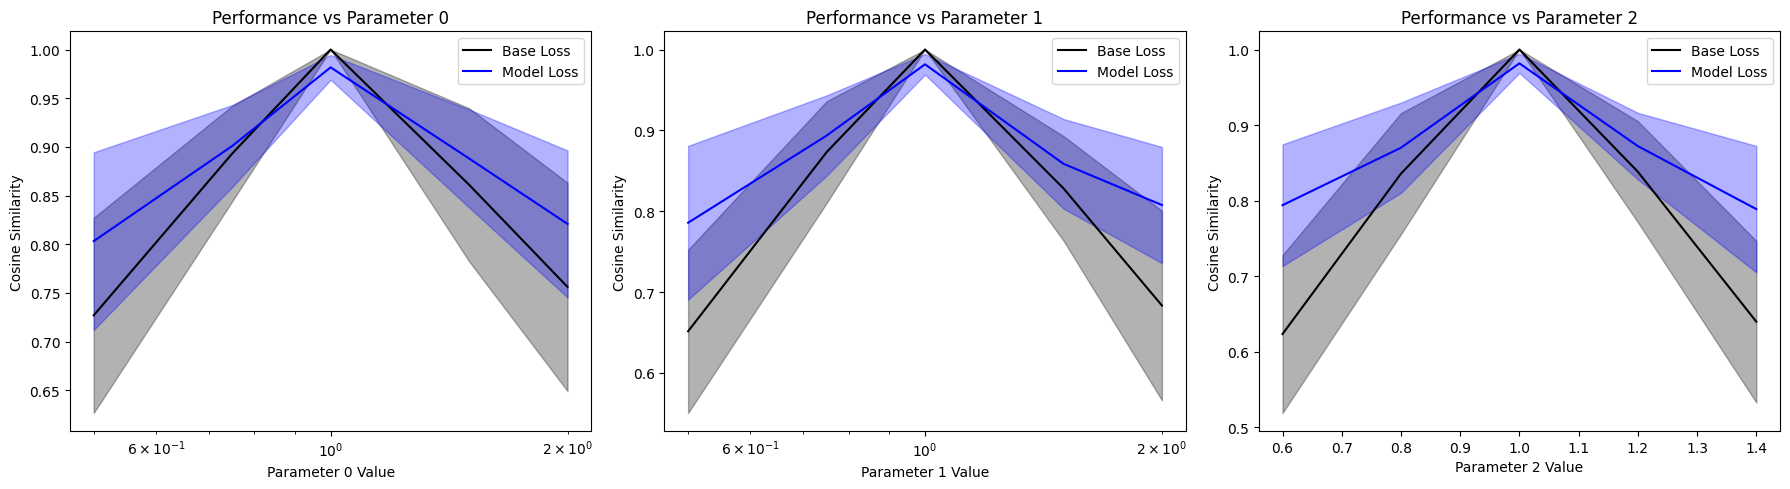

In [24]:
plot_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, drop_last = False)

val_base_descriptors, val_transformed_descriptors, val_transformations = next(iter(plot_loader))

transformations_to_plot = np.zeros((3,5,3))
transformations_to_plot[0,:,:] = transformation_list[12:124:25,:]
transformations_to_plot[1,:,:] = transformation_list[52:75:5,:]
transformations_to_plot[2,:,:] = transformation_list[60:65:1,:]

base_cosine_means = np.zeros((3,5))
base_cosine_stds = np.zeros((3,5))
model_cosine_means = np.zeros((3,5))
model_cosine_stds = np.zeros((3,5))

for i in range(3):
    for j in range(5):
        with torch.no_grad():
            target_transformation = transformations_to_plot[i,j,:]
            indices = np.where(np.all(np.array(val_transformations) == target_transformation, axis=1))[0]
    
            target_base_descriptors = val_base_descriptors[indices].to(device)
            target_transformed_descriptors = val_transformed_descriptors[indices].to(device)
            target_transformations = val_transformations[indices].to(device)
    
            base_cosines = 1 - cosine_loss(target_base_descriptors,target_transformed_descriptors,'none')
            outputs = model(target_base_descriptors.float(),target_transformations.float())
            model_cosines = 1 - cosine_loss(outputs,target_transformed_descriptors,'none')
    
            base_cosine_means[i,j] = base_cosines.mean()
            base_cosine_stds[i,j] = base_cosines.std()
            model_cosine_means[i,j] = model_cosines.mean()
            model_cosine_stds[i,j] = model_cosines.std()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

x_axes = np.array([[-0.5,-0.25,0,0.5,1.0],[-0.5,-0.25,0,0.5,1.0],[-0.4,-0.2,0,0.2,0.4]]) + 1

for i in range(3):

    axs[i].plot(x_axes[i], base_cosine_means[i], label="Base Loss", color="black")
    axs[i].plot(x_axes[i], model_cosine_means[i], label="Model Loss", color="blue")
    axs[i].fill_between(x_axes[i], base_cosine_means[i] - base_cosine_stds[i], base_cosine_means[i] + base_cosine_stds[i], color="black", alpha=0.3)
    axs[i].fill_between(x_axes[i], model_cosine_means[i] - model_cosine_stds[i], model_cosine_means[i] + model_cosine_stds[i], color="blue", alpha=0.3)
    axs[i].set_title(f"Performance vs Parameter {i}")
    axs[i].set_xlabel(f"Parameter {i} Value")
    axs[i].set_ylabel("Cosine Similarity")
    axs[i].legend()

axs[0].set_xscale('log')
axs[1].set_xscale('log')
plt.tight_layout()

plt.show()



Text(0, 0.5, 'Count')

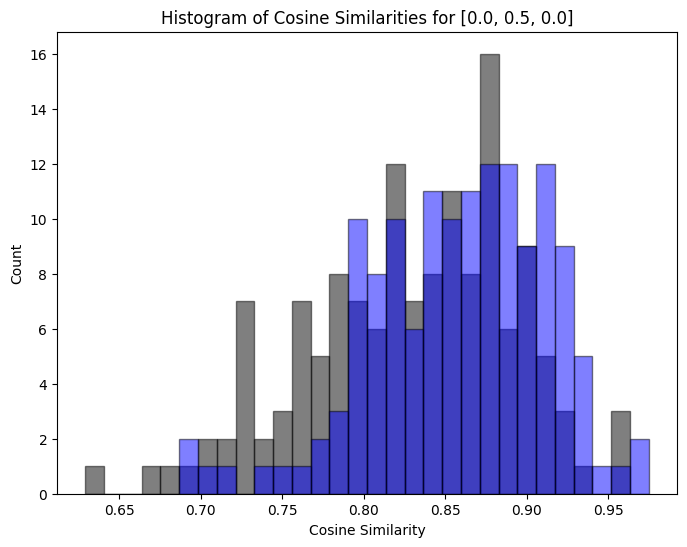

In [28]:
target_transformation = [0.0,0.5,0.0]

indices = np.where(np.all(np.array(val_transformations) == target_transformation, axis=1))[0]

with torch.no_grad():
    
    target_base_descriptors = val_base_descriptors[indices].to(device)
    target_transformed_descriptors = val_transformed_descriptors[indices].to(device)
    target_transformations = val_transformations[indices].to(device)
    
    base_cosines = 1 - cosine_loss(target_base_descriptors,target_transformed_descriptors,'none')
    outputs = model(target_base_descriptors.float(),target_transformations.float())
    model_cosines = 1 - cosine_loss(outputs,target_transformed_descriptors,'none')

base_cosines = base_cosines.cpu()
model_cosines = model_cosines.cpu()

overall_min = min(base_cosines.min(), model_cosines.min())
overall_max = max(base_cosines.max(), model_cosines.max())

bin_width = (overall_max - overall_min) / 30

bins = np.arange(overall_min, overall_max + bin_width, bin_width)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(base_cosines, bins, alpha = 0.5, color='black', edgecolor='black')
ax.hist(model_cosines, bins, alpha = 0.5, color='blue', edgecolor='black')
ax.set_title(f"Histogram of Cosine Similarities for {target_transformation}")
ax.set_xlabel("Cosine Similarity")
ax.set_ylabel("Count")